In [1]:
%load_ext autoreload
%autoreload 2
import multiprocessing
multiprocessing.set_start_method("spawn")
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import argparse
import numpy as np
import torch
import os
from collections import Counter
from tqdm.auto import tqdm
import sys
from datetime import datetime
import sys
import os
from utils import (
    same_recons, get_topk_acc, get_layer_names,
    evaluate_performance, Logger, prepare_encoders, get_layer_names_new
)
from intervention_utils import intervension


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from vis_utils import generate_shades
import matplotlib.patheffects as path_effects

def plot_topk_accuracies(top1, top2, top3, logit_scores, x_values=None, title="Top-k Accuracy and Logit Score vs. Number of Heads Included",
                         thresholds = [0.55, 0.75, 0.9], save=None, legend=True,
                         ):
    """
    Plots Top-1, Top-2, Top-3 accuracy and logit scores vs. number of heads included using twin y-axes.
    
    Args:
        top1, top2, top3 (list): Top-k accuracy values.
        logit_scores (list): Corresponding logit scores.
        x_values (list, optional): x-axis values (number of heads). Defaults to range(len(top1)).
    """
    if x_values is None:
        x_values = list(range(len(top1)))
    else:
        x_values = list(x_values)

    fig, ax2 = plt.subplots(figsize=(12, 7))
    ax1 = ax2.twinx()  
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.tick_left()

    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    topk_colors = generate_shades((0.2, 0.5, 0.9), 3)
    logit_color = (0.6, 0.4, 0.8)
    styles = ['o-', 's-', '^-', 'D--']
    styles = ['-', '-', '-', '-']
    
    labels = ['Top-1', 'Top-2', 'Top-3']
    big_size = 27
    small_size = 24
    line_width=6
    
    for y_vals, style, color, label in zip(thresholds, styles[0:3], topk_colors, labels):
        ax1.plot(x_values, [y_vals]*len(x_values), "--",  markersize=4, linewidth=line_width/2, color=color, zorder=1)
        ax1.text(
            x_values[0] - 0.3,
            y_vals + 0.01,
            f'{label} Threshold',
            fontsize=small_size - 2,
            color=color,
            ha='left',
            va='bottom',
            weight='bold',
            path_effects=[
                path_effects.Stroke(linewidth=4, foreground='white'),
                path_effects.Normal()
            ]
        )
    
    for y_vals, style, color, label in zip([top1, top2, top3], styles, topk_colors, labels):
        ax1.plot(x_values, y_vals, style, label=label, markersize=8, linewidth=line_width, color=color, zorder=2)

    ax2.plot(x_values, logit_scores, styles[-1], label='Logit Score',
             color=logit_color, markersize=7, linewidth=line_width, zorder=0)
    
    ax2.plot(x_values, [thresholds[-1]]*len(x_values), "--",  markersize=4, linewidth=line_width/2, color=logit_color, zorder=1)
    ax2.text(x_values[int(0)] - 0.3, thresholds[-1] + 0.005, f'Logit Score Threshold', 
             fontsize=small_size - 2, color=logit_color, ha='left', va='bottom', weight='bold',
             path_effects=[
                path_effects.Stroke(linewidth=6, foreground='white'),
                path_effects.Normal()
            ])
    
    ax1.set_title(title, fontsize=big_size, weight='bold', color='black')
    ax1.set_xlabel("Number of Heads Included", fontsize=small_size, weight='bold', color='black')
    ax2.set_xlabel("Number of Heads Included", fontsize=small_size, weight='bold', color='black')
    
    ax1.set_ylabel("Top-k Accuracy", fontsize=small_size, weight='bold', color='black')
    ax2.set_ylabel("Logit Score", fontsize=small_size, weight='bold', color='black')

    ax1.set_xticks(x_values[::10])
    ax1.set_xticklabels(x_values[::10], fontsize=small_size, color='black')
    ax2.set_xticklabels(x_values[::10], fontsize=small_size, color='black') 

    ax1.tick_params(axis='y', labelsize=small_size, width=2, length=6, color='black', labelcolor='black')
    ax1.tick_params(axis='x', labelsize=small_size, width=2, length=6, color='black', labelcolor='black')
    ax2.tick_params(axis='x', labelsize=small_size, width=2, length=6, color='black', labelcolor='black')
    ax2.tick_params(axis='y', labelsize=small_size, width=2, length=6, color='black', labelcolor='black')


    for spine in ax1.spines.values():
        spine.set_linewidth(3)
        spine.set_color("black")
    for spine in ax2.spines.values():
        spine.set_linewidth(3)
        spine.set_color("black")
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if legend:
        ax1.legend(lines1 + lines2, 
                labels1 + labels2, 
                loc="lower left", 
                bbox_to_anchor=(0, 0.07),
                fontsize=small_size - 4, 
                frameon=True, 
                facecolor='white')

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()


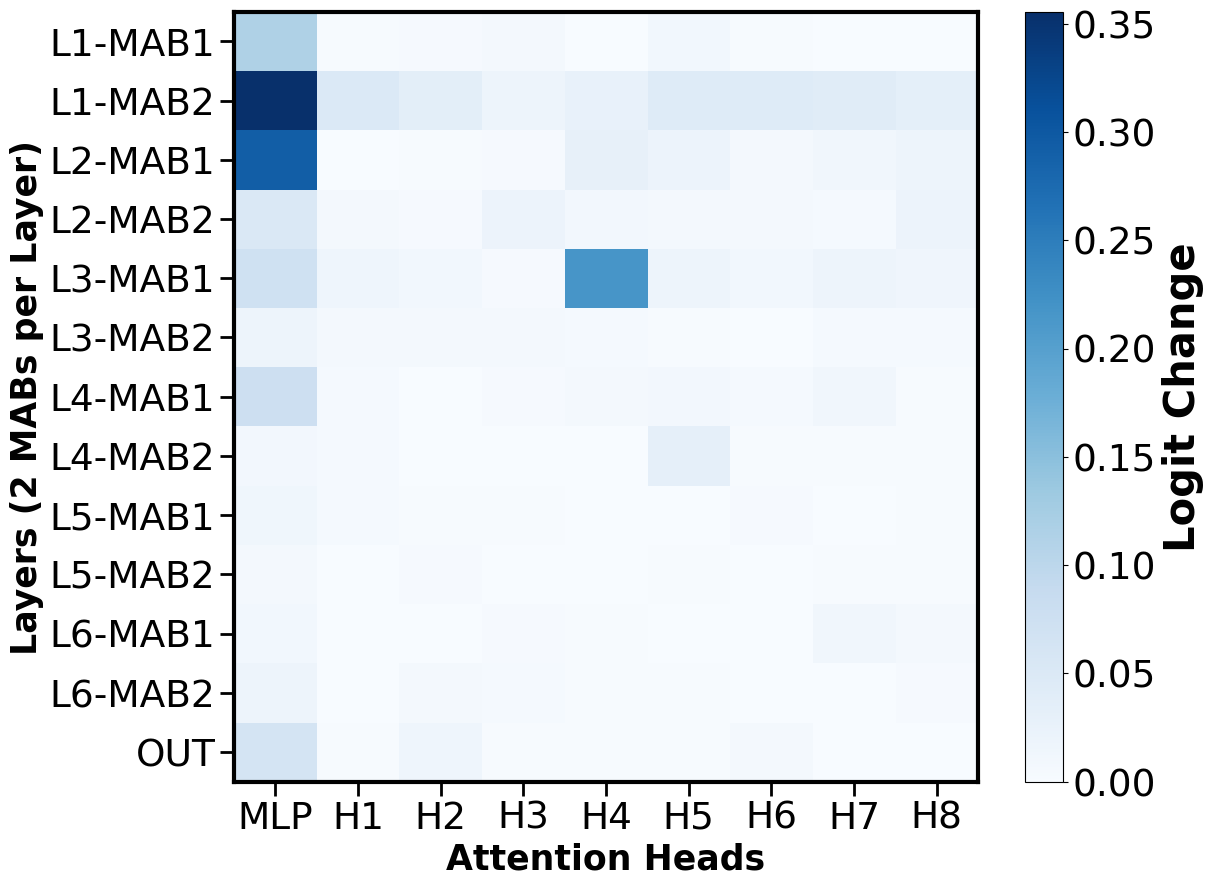

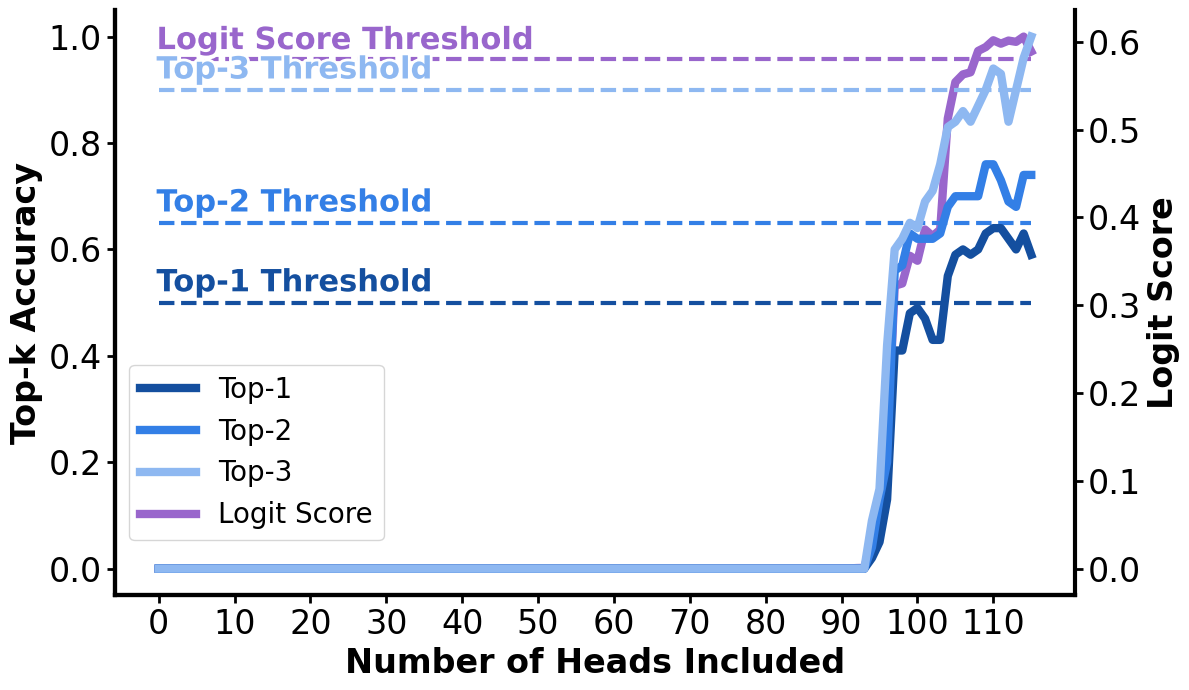

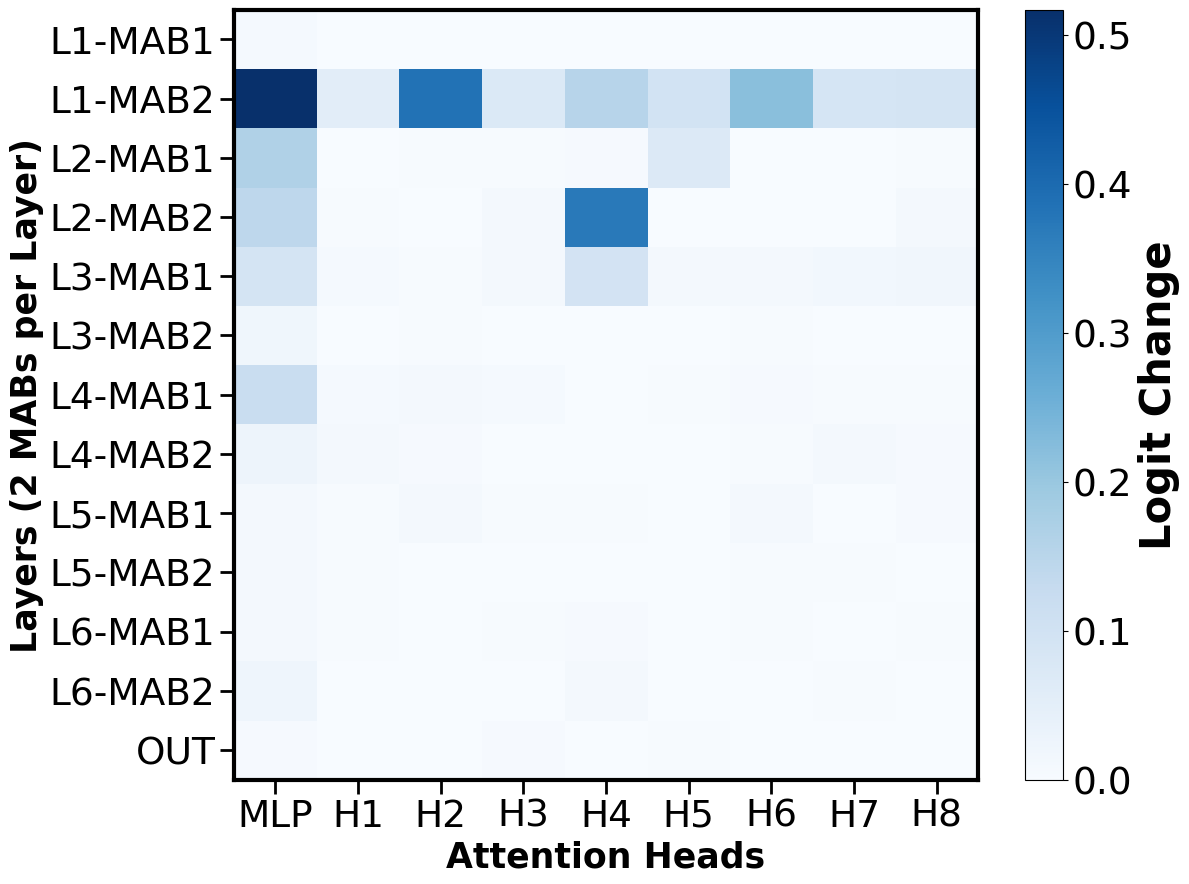

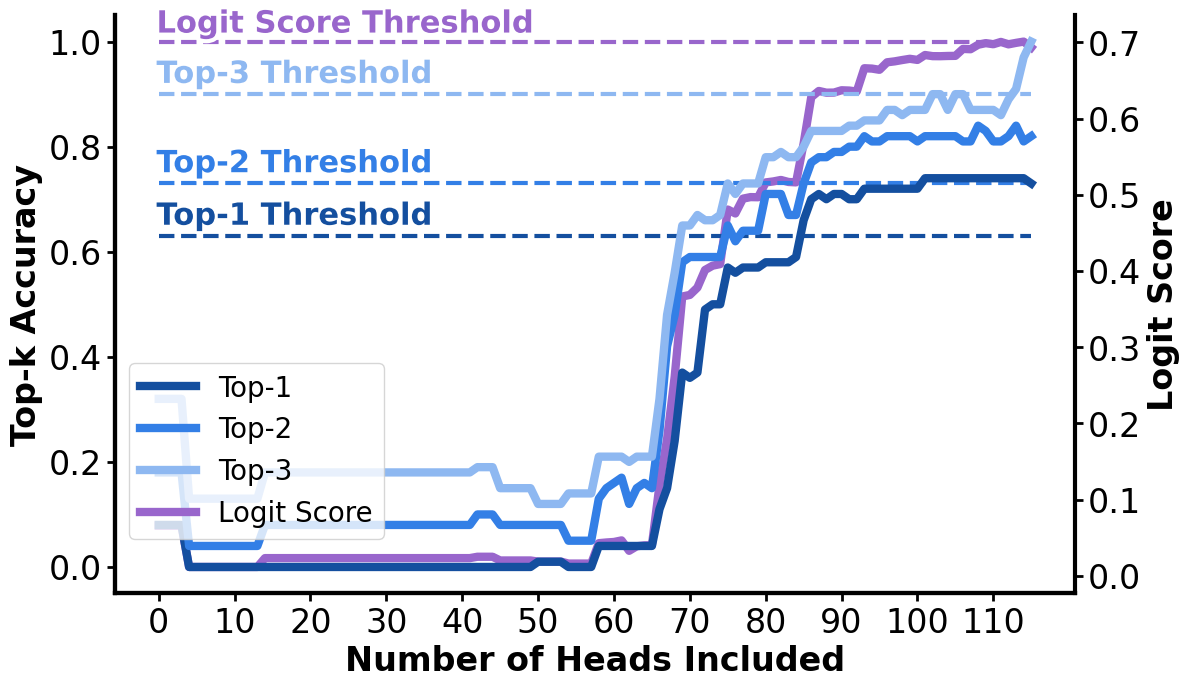

In [ ]:
from vis_utils import importance_map

operation = "sin"; patch = "mean"
data = np.load("../../data/Arco/MeanPatching/results_MEAN_sin_100.npy")
logit_scores = data[:, -1].reshape(13,9)
bliep = logit_scores[2, :]
count_matrix = np.delete(logit_scores, 2, axis=0)
logit_scores = np.vstack((count_matrix, bliep))
importance_map(logit_scores, log_scale=True, threshold=50,
               title="",
               save_fig=True,
               save_path="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/importance_sin_mean")

results = np.load(f"/home/arco/Downloads/Master/MscThesis/ExplainableDSR/data/Arco/Faitfullness/faithfulness_run_{patch}_{operation}_mean.npy")
top1, top2, top3, logit_scores = results[1:, 1], results[1:, 2], results[1:, 3], results[1:, 4]
plot_topk_accuracies(top1, top2, top3, logit_scores, x_values=None,
                     title="", thresholds=[0.63, 0.73, 0.9, 0.7],
                     save="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/topk_sin_mean.pdf")

print("\n\n\n\n\n")

operation = "exp"; patch = "mean"
data = np.load("../../data/Arco/MeanPatching/results_MEAN_exp_100.npy")
logit_scores = data[:, -1]
importance_map(logit_scores.reshape(13,9), log_scale=True, threshold=50,
               title="", show_border=False,
               save_fig=True,
               save_path="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/importance_exp_mean")
results = np.load(f"/home/arco/Downloads/Master/MscThesis/ExplainableDSR/data/Arco/Faitfullness/faithfulness_run_{patch}_{operation}_mean.npy")
top1, top2, top3, logit_scores = results[1:, 1], results[1:, 2], results[1:, 3], results[1:, 4]
plot_topk_accuracies(top1, top2, top3, logit_scores, x_values=None,
                     title="", thresholds=[0.5, 0.65, 0.9, 0.58], 
                     save="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/topk_exp_mean.pdf")

print("\n\n\n\n\n")

operation = "sin"; patch = "resample"
data = np.load("../../data/Arco/MeanPatching/results_RESAMPLE_sin_100.npy")
logit_scores = data[:, -1]
importance_map(logit_scores.reshape(13,9), log_scale=True, threshold=50,
               title="", show_border=False,
               save_fig=True,
               save_path="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/importance_sin_resample")
results = np.load(f"/home/arco/Downloads/Master/MscThesis/ExplainableDSR/data/Arco/Faitfullness/faithfulness_run_{patch}_{operation}_mean.npy")
top1, top2, top3, logit_scores = results[1:, 1], results[1:, 2], results[1:, 3], results[1:, 4]
plot_topk_accuracies(top1, top2, top3, logit_scores, x_values=None,
                     title="", thresholds=[0.63, 0.73, 0.9, 0.7], 
                     save="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/topk_sin_resample.pdf")

print("\n\n\n\n\n")

operation = "exp"; patch = "resample"
data = np.load("../../data/Arco/MeanPatching/results_RESAMPLE_exp_100.npy")
logit_scores = data[:, -1].reshape(13,9)
bliep = logit_scores[2, :]
count_matrix = np.delete(logit_scores, 2, axis=0)
logit_scores = np.vstack((count_matrix, bliep))
importance_map(logit_scores, log_scale=True, threshold=50,
               title="",
               save_fig=True,
               save_path="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/importance_exp_resample")
results = np.load(f"/home/arco/Downloads/Master/MscThesis/ExplainableDSR/data/Arco/Faitfullness/faithfulness_run_{patch}_{operation}_mean.npy")
top1, top2, top3, logit_scores = results[1:, 1], results[1:, 2], results[1:, 3], results[1:, 4]
plot_topk_accuracies(top1, top2, top3, logit_scores, x_values=None,
                     title="", thresholds=[0.5, 0.65, 0.9, 0.5], 
                     save="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/DirectLogitAttribution/topk_exp_resamople.pdf")
